In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [3]:
data_dir

'.\\datasets\\flower_photos'

In [ ]:
import pathlib

data_dir = pathlib.Path('datasets/flower_photos/flower_photos')
image_count = len(list(data_dir.glob('*/*.jpg')))  #recursive search for jpg files
print(image_count)

3670


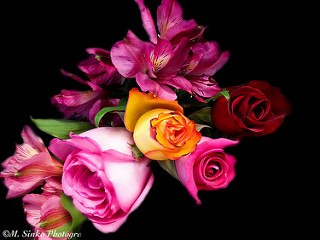

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[6]))       #PIL is Python Imaging Library that is used to open, manipulate, and save many different image  file formats

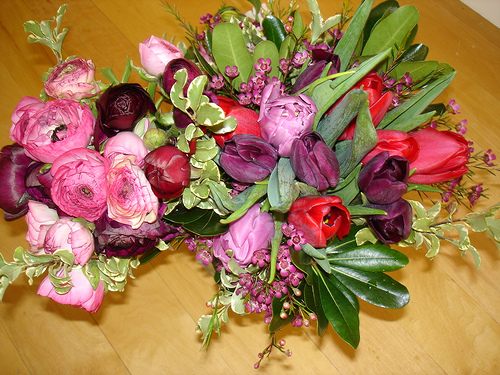

In [16]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[10]))  

In [17]:
flowers_images_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'daisy' : list(data_dir.glob('daisy/*')),
    'dandelion' : list(data_dir.glob('dandelion/*')),
    'sunflowers' : list(data_dir.glob('sunflowers/*')),
    'tulips' : list(data_dir.glob('tulips/*')),
}

In [18]:
flowers_labels_dict = {
    'roses' : 0,
    'daisy' : 1,
    'dandelion' : 2,
    'sunflowers' : 3,
    'tulips' : 4,
}

Using opencv to read images and store it in variables X(as a numpy array) and y(as labels)

In [19]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [20]:
X = np.array(X)
y = np.array(y)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
# Scalling the image sample
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255 

In [23]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)  

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.4281 - loss: 1.3437
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.5934 - loss: 1.0263
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6930 - loss: 0.8341
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.7660 - loss: 0.6397
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8387 - loss: 0.4514
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8946 - loss: 0.2914
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9451 - loss: 0.1717
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9655 - loss: 0.1138
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9836 - loss: 0.0670
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9866 - loss: 0.0498
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9967 - loss: 0.0288
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accurac

In [24]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6525 - loss: 2.3646


[2.364638328552246, 0.6525054574012756]

So we can clearly see that the model gave almost 100% accuracy for the training samples but failed miserably for the test sample.

Thus our model is overfitted

Now we work on Improving the accuracy of model by Data Augmentation

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(180,180,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

C:\Users\dhruv\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the model using data augmentation and a drop out layer

In [30]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.3943 - loss: 1.4108
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.5749 - loss: 1.0738
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.6294 - loss: 0.9668
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.6439 - loss: 0.9251
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6751 - loss: 0.8451
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6864 - loss: 0.8066
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.7057 - loss: 0.7623
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.7180 - loss: 0.7383
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.7358 - loss: 0.7105
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.7565 - loss: 0.6596
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7489 - loss: 0.6584
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step -

In [31]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7190 - loss: 0.9664


[0.9664053916931152, 0.7189542651176453]

So we can clearly see that model is not overfitted now